# Desafio Classificacao TERA: Detecção de Fraude

## Objetivo: Propor uma solução para detecção e análise de fraudes que possam reduzir os riscos da empresa e garantir margens saudáveis.

## Preparação do ambiente

Nesta seção vamos importar os pacotes que são necessários para a execução deste notebook. Estamos importando tanto pacotes que irão realizar o treinamento do modelo de Machine Learning na CPU (Sklearn) quanto o pacote que irá treinar os modelos em GPU (Rapids).

Importante: Caso você esteja executando através do Colaboratory do Google utilize essa referência para a preparação do ambiente: https://colab.research.google.com/github/ritchieng/deep-learning-wizard/blob/master/docs/machine_learning/gpu/rapids_cudf.ipynb. Este é um notebook com o passo a passo para a instalação das bibliotecas necessárias instalação das bibliotecas do Rapids.

# Importando Bibliotecas úteis

In [ ]:
from google.colab import drive #Para importar o dataset do drive

import warnings
warnings.filterwarnings('ignore')

# Bibliotecas para tratamento de dados
import pandas as pd
import numpy as np

# Bibliotecas para visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para treinamento e cálculo de métricas
from sklearn.preprocessing import Normalizer, LabelEncoder # Normalização e Encoding de variáveis
from sklearn.model_selection import train_test_split #Train_Test_Split
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.metrics import accuracy_score # Calcular Acuracia
from sklearn.metrics import precision_score #Precisao
from sklearn.metrics import recall_score # recall
from sklearn.metrics import f1_score #f1 score
from sklearn.metrics import confusion_matrix # Matriz Confusao
from sklearn.metrics import ConfusionMatrixDisplay #Display da Matriz de Confusao
from sklearn.linear_model import LogisticRegression # Regressao Logistica

#XGBoost
from xgboost import XGBClassifier

In [ ]:
# Evita que o pandas apresente valores em notação científica
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Importando Dataset

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/gdrive/MyDrive/Desafio Classificacao TERA/fraud_detection_dataset (1).csv')

In [ ]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64000,C1231006815,170136.00000,160296.36000,M1979787155,0.00000,0.00000,0,0
1,1,PAYMENT,1864.28000,C1666544295,21249.00000,19384.72000,M2044282225,0.00000,0.00000,0,0
2,1,TRANSFER,181.00000,C1305486145,181.00000,0.00000,C553264065,0.00000,0.00000,1,0
3,1,CASH_OUT,181.00000,C840083671,181.00000,0.00000,C38997010,21182.00000,0.00000,1,0
4,1,PAYMENT,11668.14000,C2048537720,41554.00000,29885.86000,M1230701703,0.00000,0.00000,0,0


## Descrevendo as variaveis:

- step - Passo: representa o total de horas transcorrido desde o início da simulação. Esta feature vai variar entre 1 e 744 (30 dias);

- type - Tipo: tipo de transação (depósito, saque, débito, pagamento e transferência);

- amount - Quantia: total que foi transacionado;

- nameOrig - ClienteOrigem: cliente que iniciou a transação

- oldbalanceOrg - SaldoInicialOrigem: saldo da conta de origem antes da transação;

- newbalanceOrig - SaldoFinalOrigem: saldo da conta de origem após a transação;

- nameDest - ClienteDestino: cliente de destino da transação;

- oldbalanceDest - SaldoInicialDestino: saldo da conta de destino antes da transação;

- newbalanceDest - SaldoFinalDestino: saldo da conta de destino após a transação;

- isFraud - ÉFraude: flag que define se a transação é fraudulenta ou não. Nesta simulação o objetivo da fraude é assumir a conta do usuário, esvaziá-la transferindo para outra conta e então sacando o dinheiro.

- isFlaggedFraud - SinalizadaComoFraude: automaticamente marcadas pelo banco como fraude por tentarem transferir mais de 200.000 em uma única transação.

## Explorando:

In [ ]:
data.isna().sum() # Nao tem NA

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [ ]:
data.type.unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

# Analise Exploratoria dos Dados (EDA)

In [ ]:
#Vamos ver quão desbalanceado é o nosso dataset, sabendo a proporção de transacoes fraudulentas do total de transacoes:
(data['isFraud'].sum()/len(data)*100) #Vemos que a proporcao de transacoes fraudulentas é de 0.129% (Extremamente desbalanceado)

0.12908204481801522

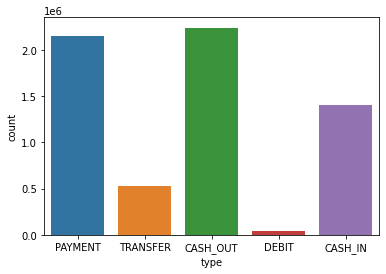

In [ ]:
#Primeiro vamos verificar a proporcao de cada tipo de transacao no nosso dataset:
sns.countplot(x = data.type)


In [ ]:
data.groupby('type')['isFraud'].sum()

type
CASH_IN        0
CASH_OUT    4116
DEBIT          0
PAYMENT        0
TRANSFER    4097
Name: isFraud, dtype: int64

## Removendo Duplicatas:

In [ ]:
len(data)

6362620

In [ ]:
data.drop_duplicates(keep = False, inplace = True)

In [ ]:
len(data) #Nao tinham duplicatas em nossos dados

6362620

## Verificando a Distribuição dos dados de transação:

In [ ]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620.00000,6362620.00000,6362620.00000,6362620.00000,6362620.00000,6362620.00000,6362620.00000,6362620.00000
mean,243.39725,179861.90355,833883.10407,855113.66858,1100701.66652,1224996.39820,0.00129,0.00000
std,142.33197,603858.23146,2888242.67304,2924048.50295,3399180.11299,3674128.94212,0.03590,0.00159
min,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,156.00000,13389.57000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,239.00000,74871.94000,14208.00000,0.00000,132705.66500,214661.44000,0.00000,0.00000
75%,335.00000,208721.47750,107315.17500,144258.41000,943036.70750,1111909.25000,0.00000,0.00000
max,743.00000,92445516.64000,59585040.37000,49585040.37000,356015889.35000,356179278.92000,1.00000,1.00000


Verificamos que na nossa variavel "Amount", apenas 25% dos valores estão abaixo de 14k. Metade dos valores estão abaixo de 75k e 25% dos valores estão acima de 200k. Sendo assim, iremos classificar essas transacoes como 'LOW' , 'MODERATE' , 'HIGH' e ' EXT HIGH', com os limites dispostos abaixo:

In [ ]:
def amount_category(x):
    if x >= 200000:
        return('EXT HIGH')
    elif x < 200000 and x >= 75000:
        return('HIGH')
    elif x < 75000 and x > 14000:
        return('MODERATE')
    else:
        return("LOW")
data['transfer_amount_category'] = data['amount'].apply(amount_category)    
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,transfer_amount_category
0,1,PAYMENT,9839.64000,C1231006815,170136.00000,160296.36000,M1979787155,0.00000,0.00000,0,0,LOW
1,1,PAYMENT,1864.28000,C1666544295,21249.00000,19384.72000,M2044282225,0.00000,0.00000,0,0,LOW
2,1,TRANSFER,181.00000,C1305486145,181.00000,0.00000,C553264065,0.00000,0.00000,1,0,LOW
3,1,CASH_OUT,181.00000,C840083671,181.00000,0.00000,C38997010,21182.00000,0.00000,1,0,LOW
4,1,PAYMENT,11668.14000,C2048537720,41554.00000,29885.86000,M1230701703,0.00000,0.00000,0,0,LOW


## Normalizando Features Numericas

In [ ]:
data_model = data

In [ ]:
norm = Normalizer()

In [ ]:
normalizer = Normalizer()
amount_scale = normalizer.fit_transform(data.amount.values.reshape(1,-1)) #Tem que dar esse primeiro reshape por ser um array a ser normalizado
data['amount_norm'] = amount_scale.reshape(-1,1) #E esse segundo para imputarmos em uma coluna
data_model['amount'] = amount_scale.reshape(-1,1)

amount_oldbalanceOrg = normalizer.fit_transform(data.oldbalanceOrg.values.reshape(1,-1))
data['oldbalanceOrg_norm'] = amount_oldbalanceOrg.reshape(-1,1)
data_model['oldbalanceOrg'] = amount_oldbalanceOrg.reshape(-1,1)

amount_newbalanceOrig = normalizer.fit_transform(data.newbalanceOrig.values.reshape(1,-1))
data['newbalanceOrig_norm'] = amount_newbalanceOrig.reshape(-1,1)
data_model['newbalanceOrig'] = amount_newbalanceOrig.reshape(-1,1)

amount_oldbalanceDest= normalizer.fit_transform(data.oldbalanceDest.values.reshape(1,-1))
data['oldbalanceDest_norm'] = amount_oldbalanceDest.reshape(-1,1)
data_model['oldbalanceDest'] = amount_oldbalanceDest.reshape(-1,1)

amount_newbalanceDest = normalizer.fit_transform(data.newbalanceDest.values.reshape(1,-1))
data['newbalanceDest_norm'] = amount_newbalanceDest.reshape(-1,1)
data_model['newbalanceDest'] = amount_newbalanceDest.reshape(-1,1)

In [ ]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,transfer_amount_category,amount_norm,oldbalanceOrg_norm,newbalanceOrig_norm,oldbalanceDest_norm,newbalanceDest_norm
0,1,PAYMENT,0.00001,C1231006815,0.00002,0.00002,M1979787155,0.00000,0.00000,0,0,LOW,0.00001,0.00002,0.00002,0.00000,0.00000
1,1,PAYMENT,0.00000,C1666544295,0.00000,0.00000,M2044282225,0.00000,0.00000,0,0,LOW,0.00000,0.00000,0.00000,0.00000,0.00000
2,1,TRANSFER,0.00000,C1305486145,0.00000,0.00000,C553264065,0.00000,0.00000,1,0,LOW,0.00000,0.00000,0.00000,0.00000,0.00000
3,1,CASH_OUT,0.00000,C840083671,0.00000,0.00000,C38997010,0.00000,0.00000,1,0,LOW,0.00000,0.00000,0.00000,0.00000,0.00000
4,1,PAYMENT,0.00001,C2048537720,0.00001,0.00000,M1230701703,0.00000,0.00000,0,0,LOW,0.00001,0.00001,0.00000,0.00000,0.00000


# Modelagem:

In [ ]:
#Train Test Split
X = data[['type','amount_norm','transfer_amount_category','nameOrig','oldbalanceOrg_norm','newbalanceOrig_norm','nameDest','oldbalanceDest_norm','newbalanceDest_norm']]
Y = data[['isFraud']]
X.head()

,type,amount_norm,transfer_amount_category,nameOrig,oldbalanceOrg_norm,newbalanceOrig_norm,nameDest,oldbalanceDest_norm,newbalanceDest_norm
0,PAYMENT,0.00001,LOW,C1231006815,0.00002,0.00002,M1979787155,0.00000,0.00000
1,PAYMENT,0.00000,LOW,C1666544295,0.00000,0.00000,M2044282225,0.00000,0.00000
2,TRANSFER,0.00000,LOW,C1305486145,0.00000,0.00000,C553264065,0.00000,0.00000
3,CASH_OUT,0.00000,LOW,C840083671,0.00000,0.00000,C38997010,0.00000,0.00000
4,PAYMENT,0.00001,LOW,C2048537720,0.00001,0.00000,M1230701703,0.00000,0.00000


### Train Test Split

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,
                                                 test_size = 0.3,
                                                 stratify = Y,
                                                 random_state = 10)

## Lidando com as Features Categoricas utilizando o Target Encoder:

In [ ]:
!pip install category_encoders
from category_encoders.target_encoder import TargetEncoder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
TE = TargetEncoder()
cat_vars = ['type','transfer_amount_category','nameOrig','nameDest']
#Fit Transform no Treino
X_train[cat_vars] = TE.fit_transform(X_train[cat_vars],y_train)

In [ ]:
X_train.head()

,type,amount_norm,transfer_amount_category,nameOrig,oldbalanceOrg_norm,newbalanceOrig_norm,nameDest,oldbalanceDest_norm,newbalanceDest_norm
3035847,0.00000,0.00000,0.00021,0.00129,0.00000,0.00000,0.00129,0.00000,0.00000
1837871,0.00000,0.00001,0.00021,0.00129,0.00000,0.00000,0.00129,0.00000,0.00000
1032956,0.00000,0.00009,0.00090,0.00129,0.00107,0.00107,0.00000,0.00004,0.00000
1117320,0.00183,0.00012,0.00090,0.00129,0.00003,0.00001,0.00000,0.00027,0.00026
4191999,0.00000,0.00001,0.00067,0.00129,0.00000,0.00000,0.00129,0.00000,0.00000


In [ ]:
X_test[cat_vars] = TE.transform(X_test[cat_vars]) #transform no teste

In [ ]:
X_test.head()

,type,amount_norm,transfer_amount_category,nameOrig,oldbalanceOrg_norm,newbalanceOrig_norm,nameDest,oldbalanceDest_norm,newbalanceDest_norm
2843011,0.00183,0.00045,0.00328,0.00129,0.00000,0.00000,0.00000,0.00004,0.00011
6267838,0.00183,0.00007,0.00090,0.00129,0.00000,0.00000,0.00000,0.00008,0.00009
3037018,0.00183,0.00022,0.00328,0.00129,0.00003,0.00000,0.00000,0.00008,0.00011
281323,0.00183,0.00020,0.00328,0.00129,0.00002,0.00000,0.00000,0.00000,0.00003
3373191,0.00000,0.00000,0.00021,0.00129,0.00000,0.00000,0.00129,0.00000,0.00000


In [ ]:
X_train.dtypes

type                        float64
amount_norm                 float64
transfer_amount_category    float64
nameOrig                    float64
oldbalanceOrg_norm          float64
newbalanceOrig_norm         float64
nameDest                    float64
oldbalanceDest_norm         float64
newbalanceDest_norm         float64
dtype: object

In [ ]:
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)

## Treinando Regressao Logistica

In [ ]:
# Criando o modelo Regressão Logistica em CPU
model_reglog = LogisticRegression()   
  
# Treinamento do modelo Regressão Logistica em CPU
model_reglog.fit(X_train, y_train) 

LogisticRegression()

In [ ]:
y_pred_reglog = model_reglog.predict(X_test)

In [ ]:
# Calculando as métricas do modelo (Acurácia, Matriz de confusão)
print("Acurácia: ", accuracy_score(y_test, y_pred_reglog))
print("Precisao: ", precision_score(y_test, y_pred_reglog))
print("Recall: ", recall_score(y_test, y_pred_reglog))
print("F1 Score: ", f1_score(y_test, y_pred_reglog))
print("Matriz de confusão:\n ", confusion_matrix(y_test, y_pred_reglog))

Acurácia:  0.9985278601163252
Precisao:  0.0028735632183908046
Recall:  0.00040584415584415587
F1 Score:  0.0007112375533428165
Matriz de confusão:
  [[1905975     347]
 [   2463       1]]


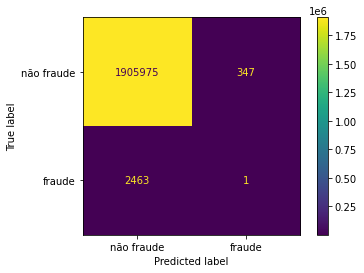

In [ ]:
cm = confusion_matrix(y_test, y_pred_reglog)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['não fraude', 'fraude'])
ax = disp.plot(values_format='d') 

## Treinando Random Forest

In [ ]:
# Criando o modelo Random Forest em CPU
model_rf = RandomForestClassifier(n_estimators = 5, random_state = 10)   
  
# Treinamento do modelo Random Forest em CPU
model_rf.fit(X_train, y_train) 

RandomForestClassifier(n_estimators=5, random_state=10)

In [ ]:
# Predições
y_pred_rf = model_rf.predict(X_test) 

In [ ]:
# Calculando as métricas do modelo (Acurácia, Matriz de confusão)
print("Acurácia: ", accuracy_score(y_test, y_pred_rf))
print("Precisao: ", precision_score(y_test, y_pred_rf))
print("Recall: ", recall_score(y_test, y_pred_rf))
print("F1 Score: ", f1_score(y_test, y_pred_rf))
print("Matriz de confusão:\n ", confusion_matrix(y_test, y_pred_rf))

Acurácia:  0.99928383799965
Precisao:  0.9183829138062548
Recall:  0.48863636363636365
F1 Score:  0.6378807947019868
Matriz de confusão:
  [[1906215     107]
 [   1260    1204]]


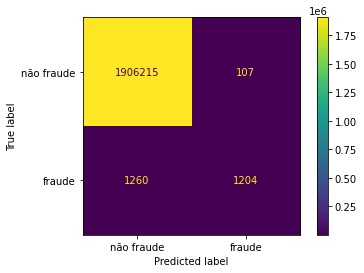

In [ ]:
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['não fraude', 'fraude'])
ax = disp.plot(values_format='d') 

## Treinando XGBoost

In [ ]:

# Parametrização do XGBoost
params = {'learning_rate': 0.1,
          'colsample_bytree' : 0.3,
          'max_depth': 5,
          'objective': 'binary:logistic',
          'alpha' : 10,
          'n_estimators': 100}

# Treinamento do modelo XGBoost
model_xgb = XGBClassifier(**params)
model_xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
                      eval_metric='auc', verbose=False)

[23:07:59] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


XGBClassifier(alpha=10, colsample_bytree=0.3, max_depth=5)

In [ ]:
# Predições
y_pred_xgb = model_xgb.predict(X_test) 

In [ ]:
print("Acurácia: ", accuracy_score(y_test, y_pred_xgb))
print("Precisao: ", precision_score(y_test, y_pred_xgb))
print("Recall: ", recall_score(y_test, y_pred_xgb))
print("F1 Score: ", f1_score(y_test, y_pred_xgb))
print("Matriz de confusão:\n ", confusion_matrix(y_test, y_pred_xgb))

Acurácia:  0.9990339409446632
Precisao:  0.9798761609907121
Recall:  0.25689935064935066
F1 Score:  0.40707395498392285
Matriz de confusão:
  [[1906309      13]
 [   1831     633]]


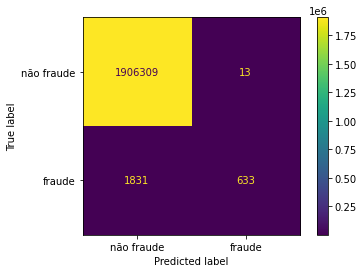

In [ ]:
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['não fraude', 'fraude'])
ax = disp.plot(values_format='d') 

# Interpretando Resultados:

## Acurácia:

A Acuracia é a métrica mais simples, ela representa o numero de previsões corretas do modelo. Entretanto, para dados muito desbalanceados (como é o nosso caso), ela pode dar uma falsa impressão de que nossa modelo está performando de maneira fantástica, pelo simples fato de apenas 0.12% das nossas amostras ser Fraudulenta. Se nosso modelo classificar todas as amostras como não fraudulentas, ele já atingiria uma acurácia de 99.88%

## Precisao

Essa métrica indica nosso poder de previsão de positivos. Dentre todas as observações classificadas como positiva, quais são realmente positivas? No nosso caso, prever corretamente um "positivo" significa identificar uma fraude. Um falso negativo pode gerar ao banco e aos seus clientes uma grande dor de cabeça com perdas de grandes quantias monetárias, enquanto um falso positivo apenas pode ocasionar uma checagem de validez da transação, mantendo a segurança do cliente. Essa é uma métrica bem importante para o problema em questão!

## Recall

O Recall também diz respeito ao poder de previsão de positivos. "Dentre todas as observações que são realmente positivas, em quantas o modelo conseguiu identificar corretamente?". Também uma métrica muito importante para este problema

## F1 Score

Média Harmonica entre Recall e Precisao. Muito utilizada quando temos classes desbalanceadas, que é o nosso caso. Outra métrica muito importante!

# Comparacao de Metricas:

Regressao Logistica: 

* Acurácia:  0.9985278601163252
* Precisao:  0.0028735632183908046
* Recall:  0.00040584415584415587
* F1 Score:  0.0007112375533428165

Random Forest:

* Acurácia:  0.99928383799965
* Precisao:  0.9183829138062548
* Recall:  0.48863636363636365
* F1 Score:  0.6378807947019868

XGBoost:

* Acurácia:  0.9990339409446632
* Precisao:  0.9798761609907121
* Recall:  0.25689935064935066
* F1 Score:  0.40707395498392285

# Conclusão: Analisando todas as métricas e pela descrição delas acima, elegemos a Random Forest como o melhor modelo desta leva. Vale ressaltar que esses são os modelos baseline, e uma tunagem de hiperparametros pode (e será) feita posteriormente utilizando, por exemplo, o GridSearchCV, para encontrar os melhores hiperparametros para um modelo mais refinado.